In [1]:
import mlflow.pyfunc
import shap

X, y = shap.datasets.california(n_points=1000)

X100 = shap.utils.sample(X, 100)  # 100 instances for use as the background distribution

In [24]:
model_name = "Production-model"
model_version = 1
rel_path = "../data/mlruns/"
mlflow.set_tracking_uri(f"file:{rel_path}")
model = mlflow.pyfunc.load_model(model_uri=f"models:/{model_name}/{model_version}", suppress_warnings=True)

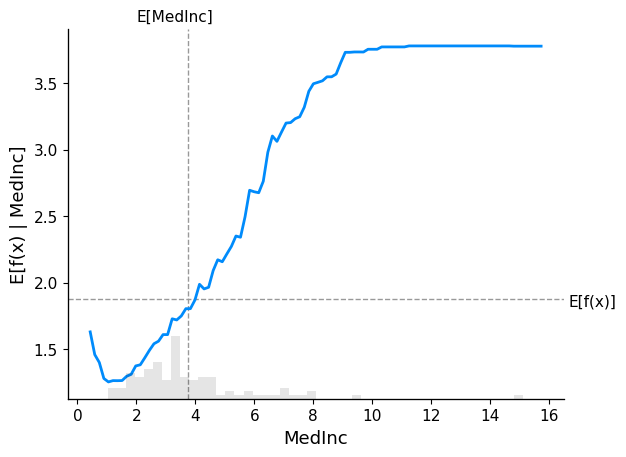

In [25]:
shap.partial_dependence_plot(
    "MedInc",
    model.predict,
    X100,
    ice=False,
    model_expected_value=True,
    feature_expected_value=True,
)

In [17]:
print(type(model))

<class 'mlflow.entities.model_registry.registered_model.RegisteredModel'>
